In [1]:
import sys
print(sys.executable)

sys.path.append('../../')
print(sys.path)

/home/mshunya/project/100_GQCO/GQCO/.env/bin/python3.11
['/home/mshunya/.pyenv/versions/3.11.7/lib/python311.zip', '/home/mshunya/.pyenv/versions/3.11.7/lib/python3.11', '/home/mshunya/.pyenv/versions/3.11.7/lib/python3.11/lib-dynload', '', '/home/mshunya/project/100_GQCO/GQCO/.env/lib/python3.11/site-packages', '../../']


In [2]:
import pickle
import json
import time
import tqdm
import heapq
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, Math
from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import Statevector

from gqco.solve import solve_from_token, plot_from_dict, brute_solver, probs_to_result

In [3]:
def result_to_dict(result, dict_base, is_flip=False):
    try:
        string_data = [''.join(map(str, sublist)) for sublist in result['measurements']]
        counts = Counter(string_data)
        total_count = sum(counts.values())
        dct = {seq: count / total_count for seq, count in counts.items()}
    except:
        dct = result['measurementProbabilities']

    if is_flip:
        dct = {''.join('1' if bit == '0' else '0' for bit in key): value for key, value in dct.items()}

    out = {}
    for key in dict_base:
        if key in dct:
            out[key] = dct[key]
        else:
            out[key] = 0

    return out

In [4]:
def plot_from_dict(dict_pred, dict_true, savefile, is_legend=False, figsize=(5, 4), is_true=True):

    dict_pred = {key: dict_pred[key] for key in dict_true if key in dict_pred}

    # Extract keys and values
    keys = list(dict_pred.keys())
    values_pred = list(dict_pred.values())
    values_true = list(dict_true.values())

    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create a bar plot for dict A
    ax1.grid(axis='x', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=0)
    ax1.bar(keys, values_pred, color=sns.color_palette('Blues', 24)[12], label="Machine's answer", alpha=1, zorder=2)
    ax1.set_xlabel('Keys', size=11)
    ax1.set_ylabel("Probability amplitude", size=11)
    ax1.tick_params(axis="y")


    if is_true:
        # Create the second axis
        ax2 = ax1.twinx()
        
        # Create a scatter plot for dict B
        min_value = min(values_true)
        min_indices = [i for i, value in enumerate(values_true) if value == min_value]
        
        # Scatter plot with different color for the minimum value
        colors = [sns.color_palette('Blues', 24)[-1]] * len(values_true)
        for i in min_indices:
            colors[i] = 'tomato'  # Change color of the minimum value
        
        ax2.scatter(keys, values_true, color=colors, label='Exact value', zorder=3, s=1)
        ax2.set_ylabel('True cost', size=11)
        ax2.tick_params(axis='y')

    ax1.set_xlabel(None)

    
    # Show the plot
    if is_legend:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.96), ncol=2)
    ax1.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(f'{savefile}-probs.svg', bbox_inches='tight')
    plt.show()

In [5]:
def plot_from_dict(dict_pred, dict_true, savefile, is_legend=False, figsize=(5, 4), is_true=True, is_xticks=True):
    dict_pred = {key: dict_pred[key] for key in dict_true if key in dict_pred}

    # Extract keys and values
    keys = list(dict_pred.keys())
    values_pred = list(dict_pred.values())
    values_true = list(dict_true.values())

    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create a bar plot for dict A
    # ax1.grid(axis='x', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=0)
    ax1.bar(keys, values_pred, color=sns.color_palette('Blues', 24)[12], label="Machine's answer", alpha=1, zorder=2)
    # ax1.set_xlabel('Keys', size=11)
    ax1.set_ylabel("Probability amplitude", size=11)
    ax1.tick_params(axis="y")

    if is_true:
        # Create the second axis
        ax2 = ax1.twinx()
        
        # Identify the minimum values
        min_value = min(values_true)
        min_indices = [i for i, value in enumerate(values_true) if value == min_value]
        
        # Scatter plot with customized color and size for minimum value points
        colors = ['tomato' if i in min_indices else sns.color_palette('Blues', 24)[-1] for i in range(len(values_true))]
        sizes = [20 if i in min_indices else 1 for i in range(len(values_true))]
        
        ax2.scatter(keys, values_true, color=colors, label='Exact value', zorder=3, s=sizes)
        ax2.set_ylabel('True cost', size=11)
        ax2.tick_params(axis='y')

    # Remove x-tick labels for non-min indices
    x_labels = [key if i in min_indices else '' for i, key in enumerate(keys)]
    ax1.set_xticks(range(len(keys)))
    ax1.set_xticklabels(x_labels, rotation=90)

    if not is_xticks:
        ax1.set_xticklabels([])
    
    # Show the plot
    if is_legend:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.96), ncol=2)
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(f'{savefile}-probs.svg', bbox_inches='tight')
    plt.show()

In [6]:
def get_state(qc):
    vector = Statevector(qc)
    array = []
    for v in vector:
        array.append(v)
    return np.array(array)

def draw_and_save(qc, dict_real=None, savename=None):
    fname1 = None
    fname2 = None
    fname3 = None
    if savename is not None:
        fname1 = savename+'-circ.svg'
        fname2 = savename+'Sim'
        fname3 = savename+'Real'
    display(qc.draw(output='mpl', style='bw', scale=0.75, fold=41, filename=fname1))

    vec = get_state(qc)
    probs = np.abs(vec)**2
    dict_pred = probs_to_result(probs)
    plot_from_dict(dict_pred, dict_true, savefile=fname2, figsize=(15, 4))
    plot_from_dict(dict_real, dict_true, savefile=fname3, figsize=(20, 4), is_xticks=False)
    

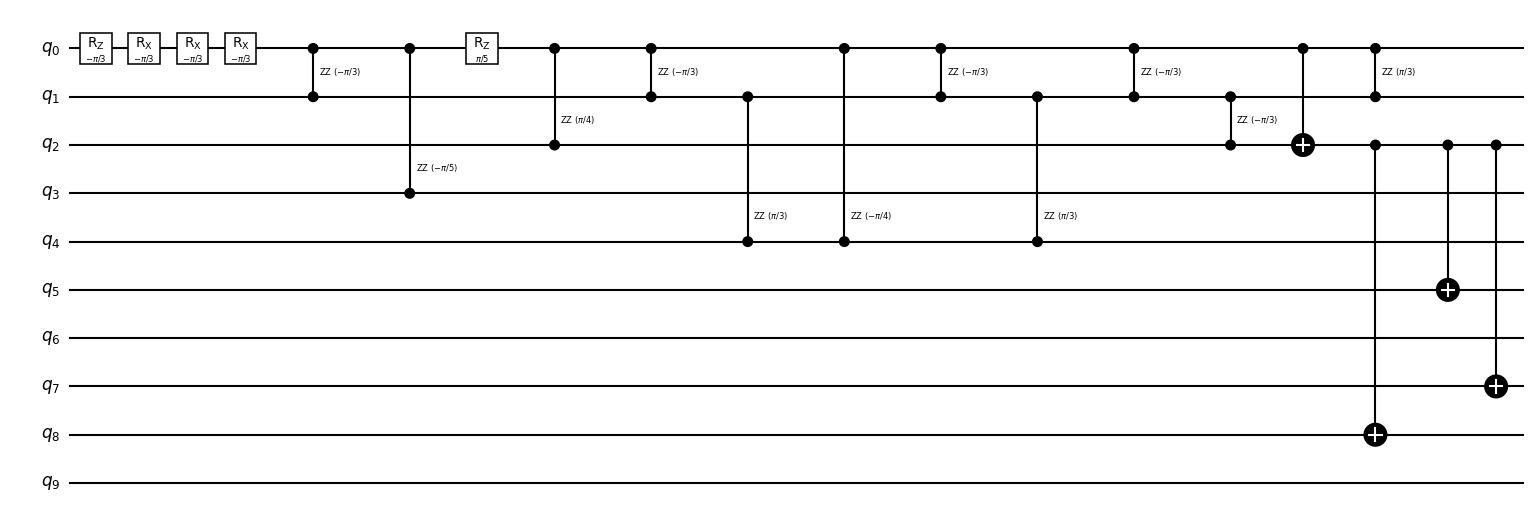

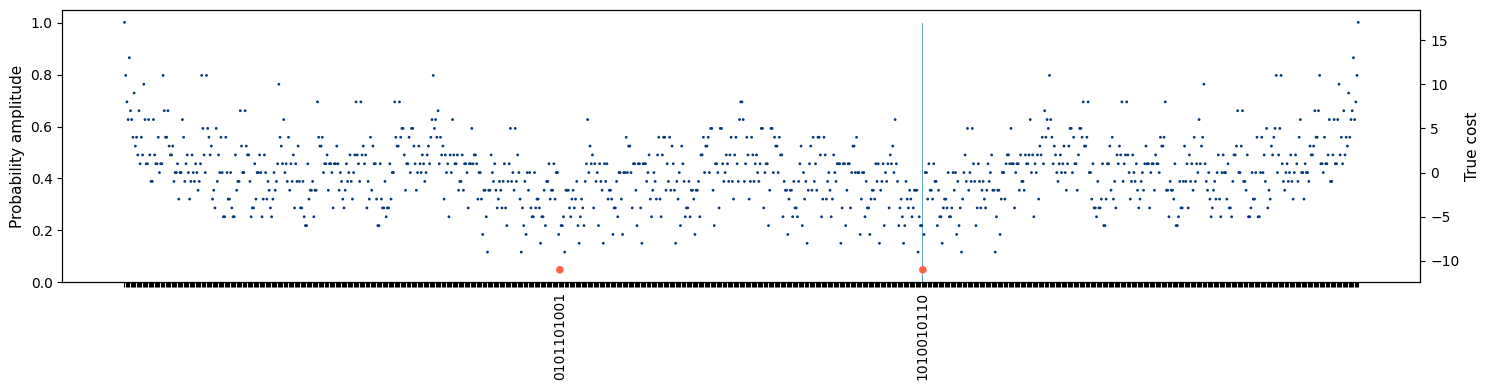

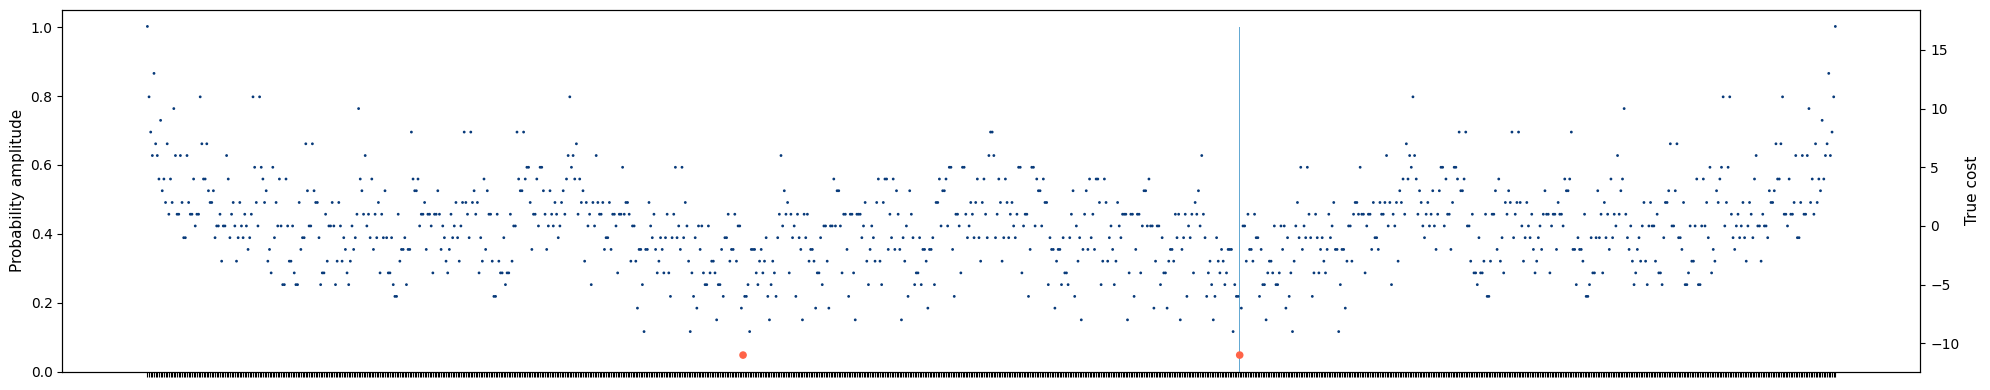

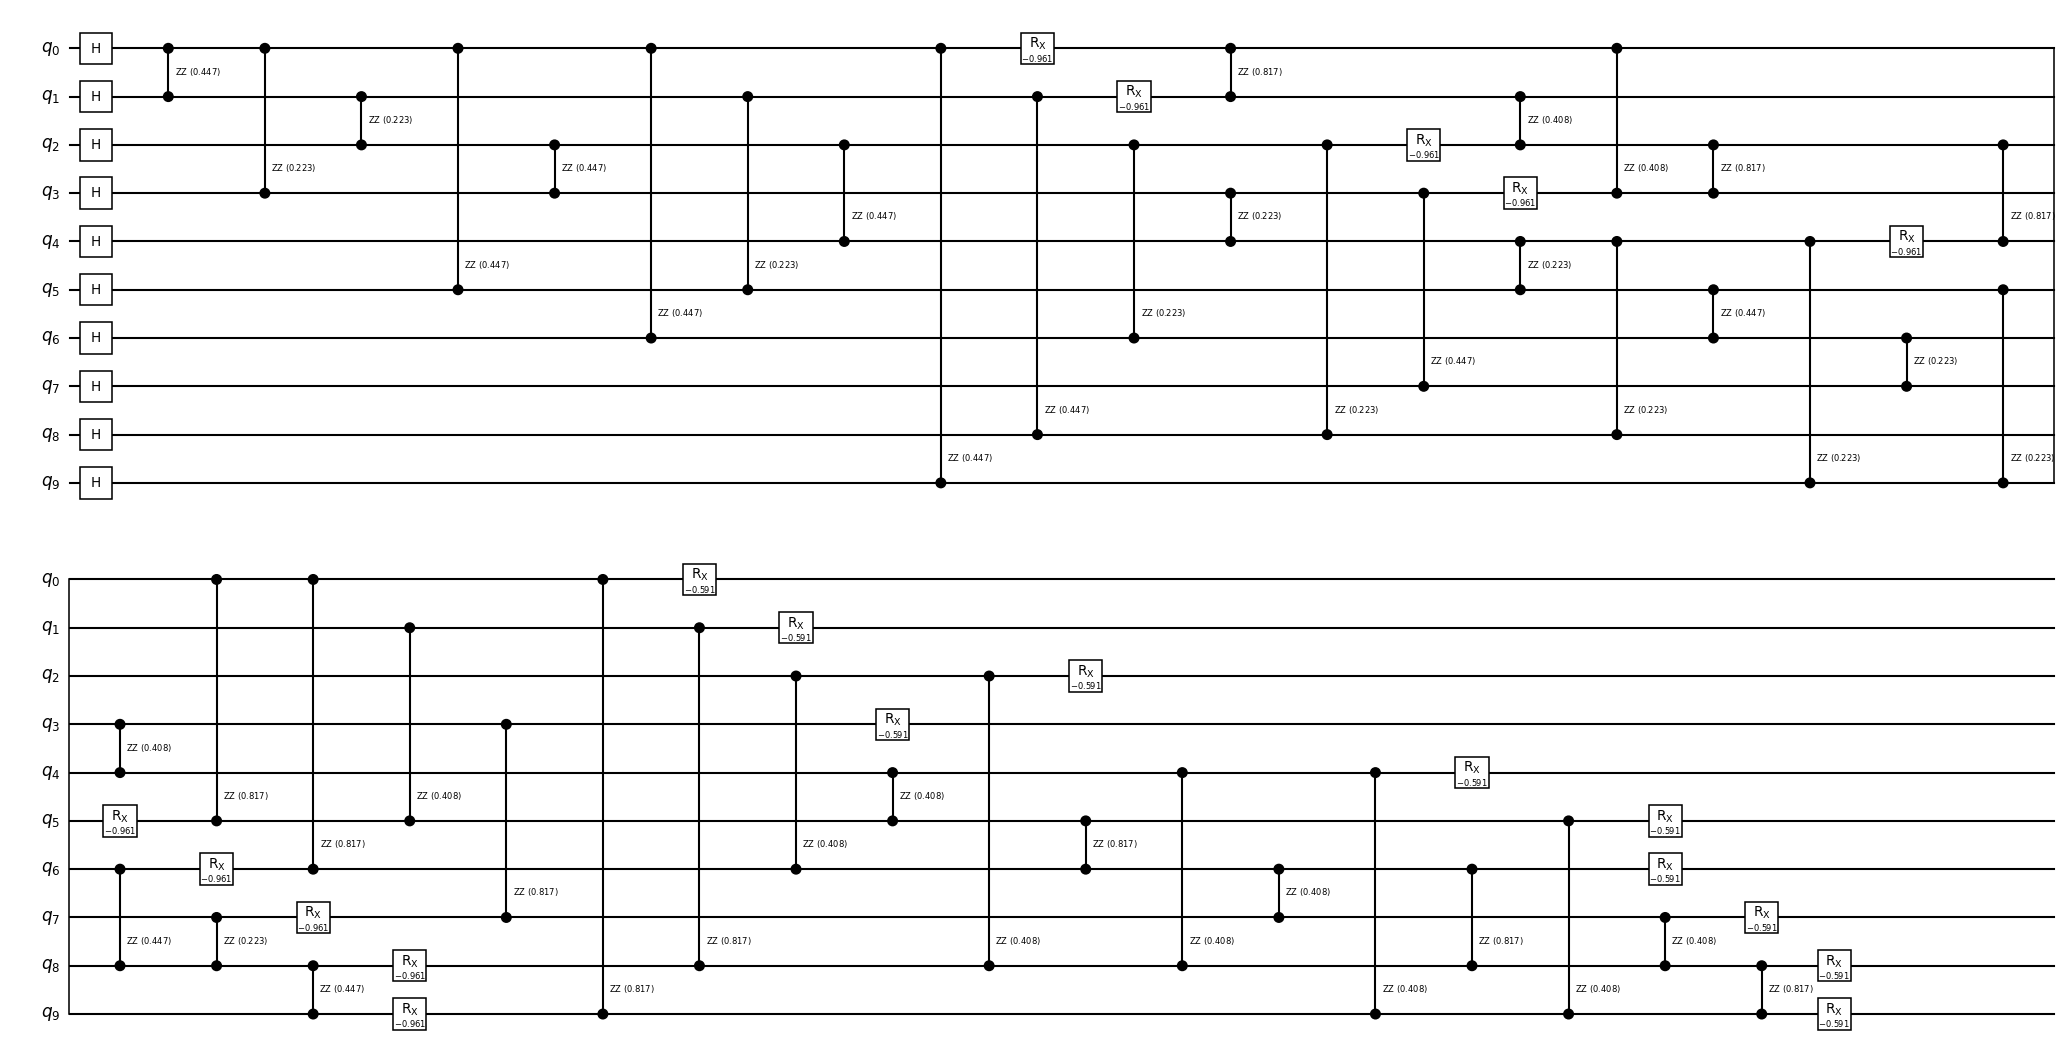

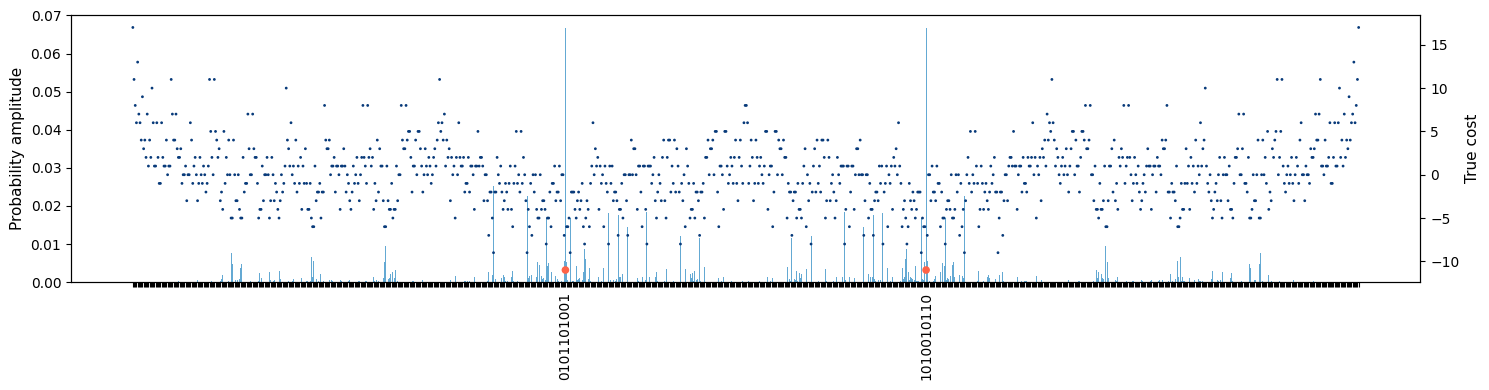

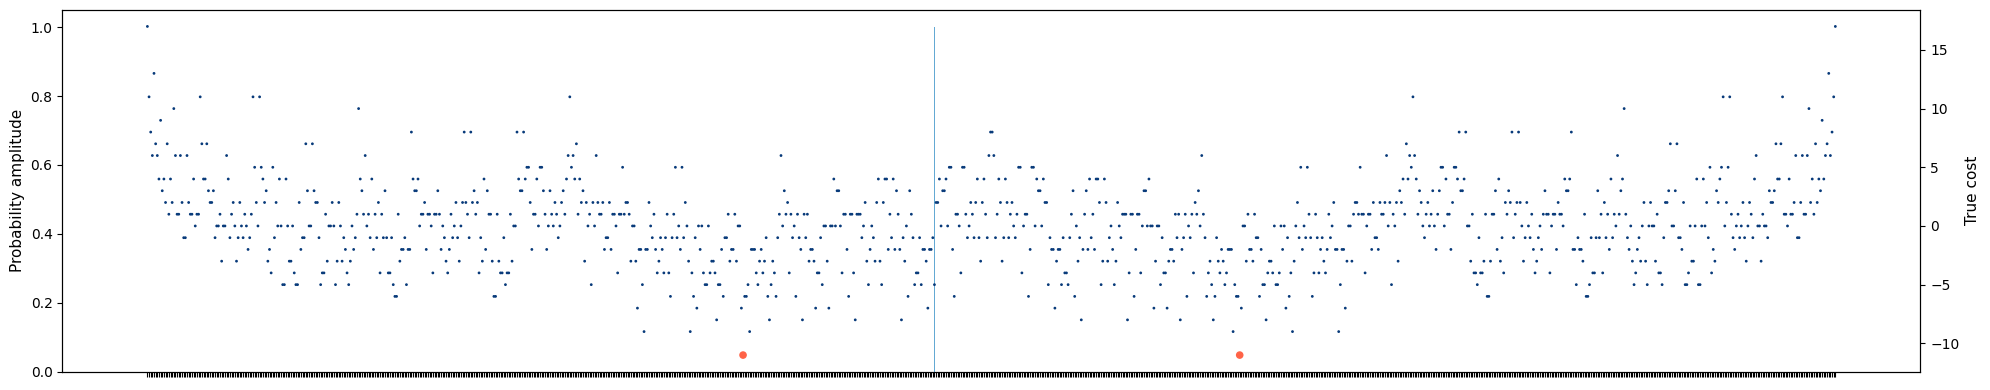

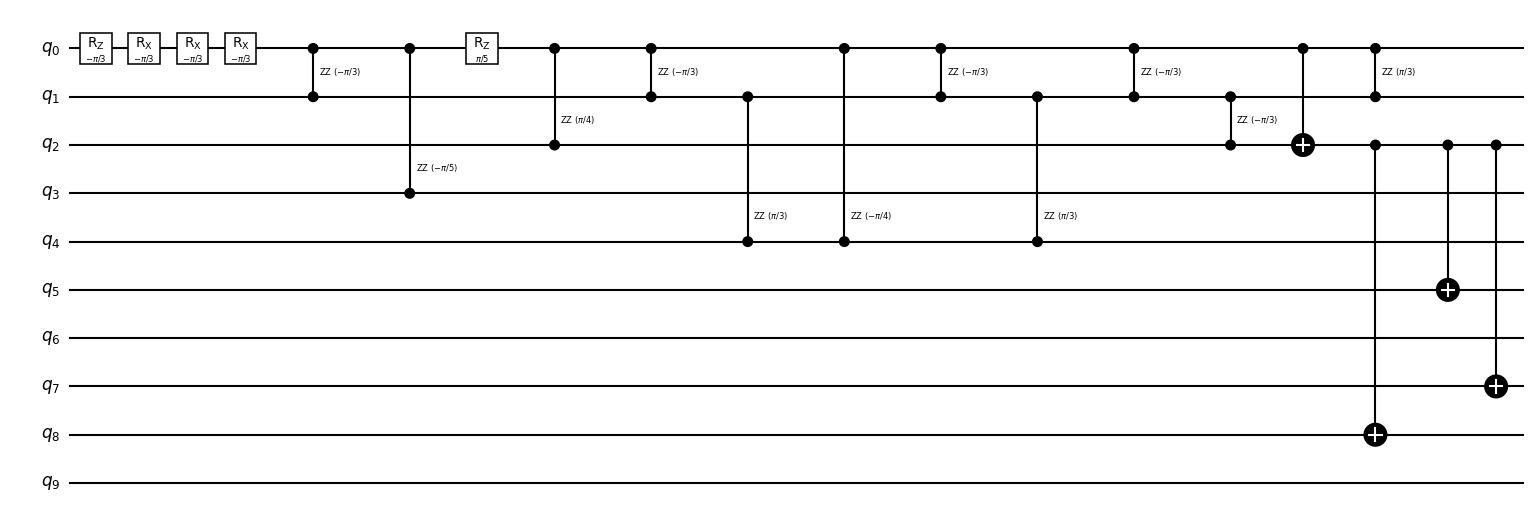

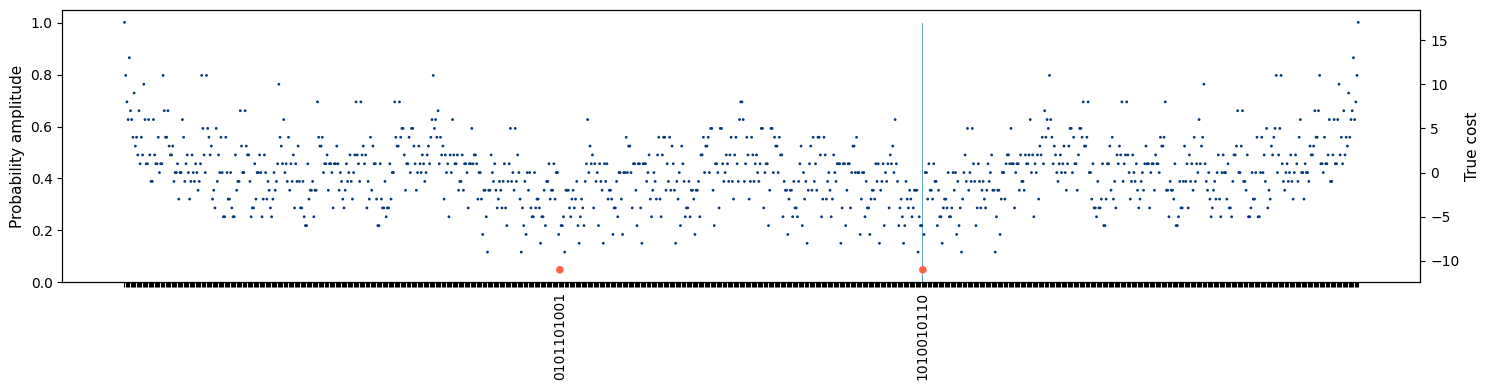

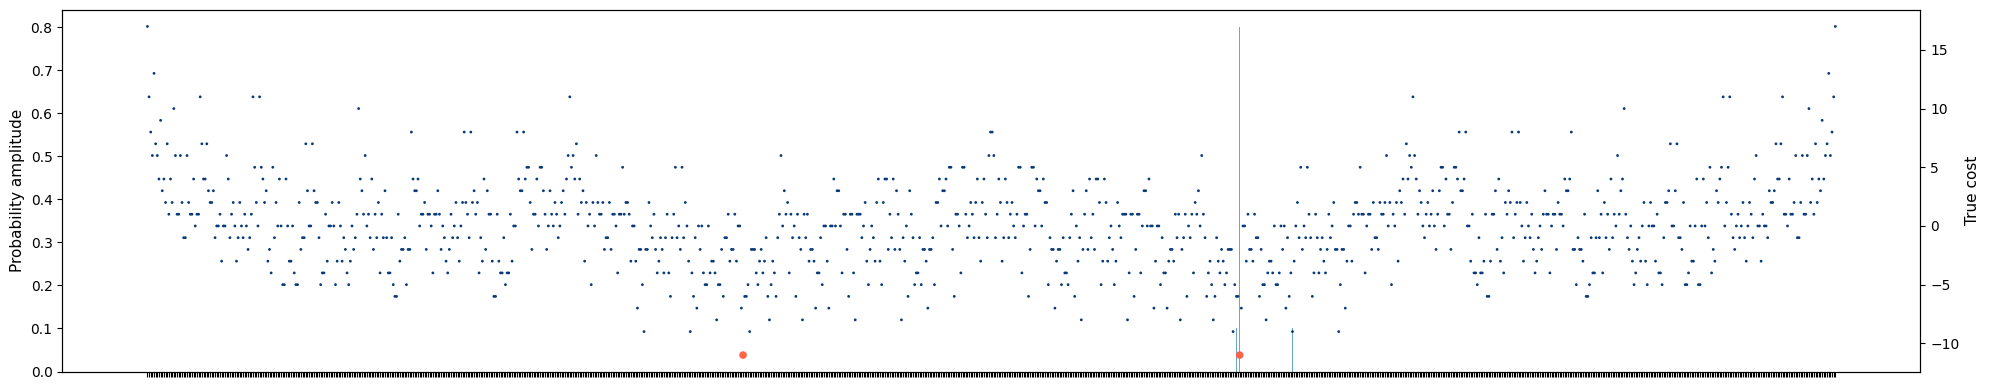

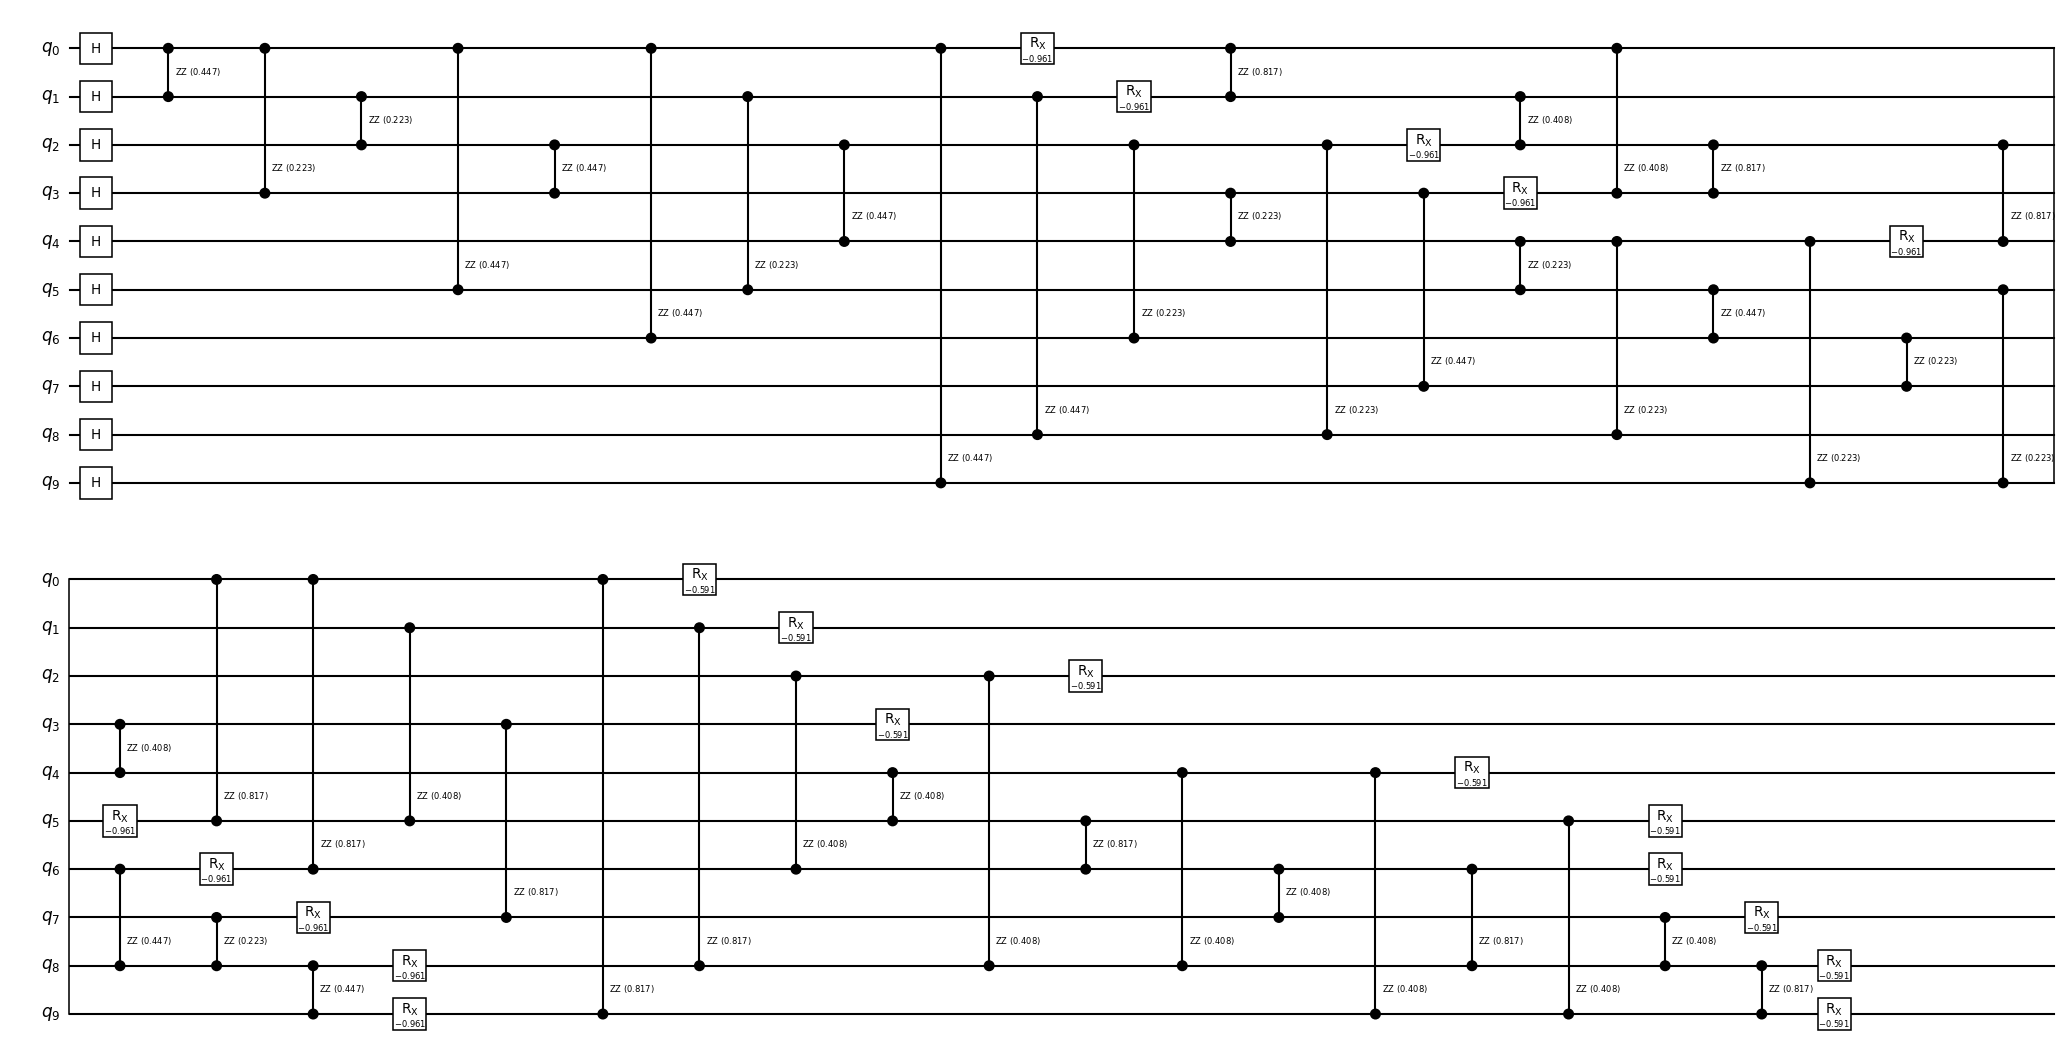

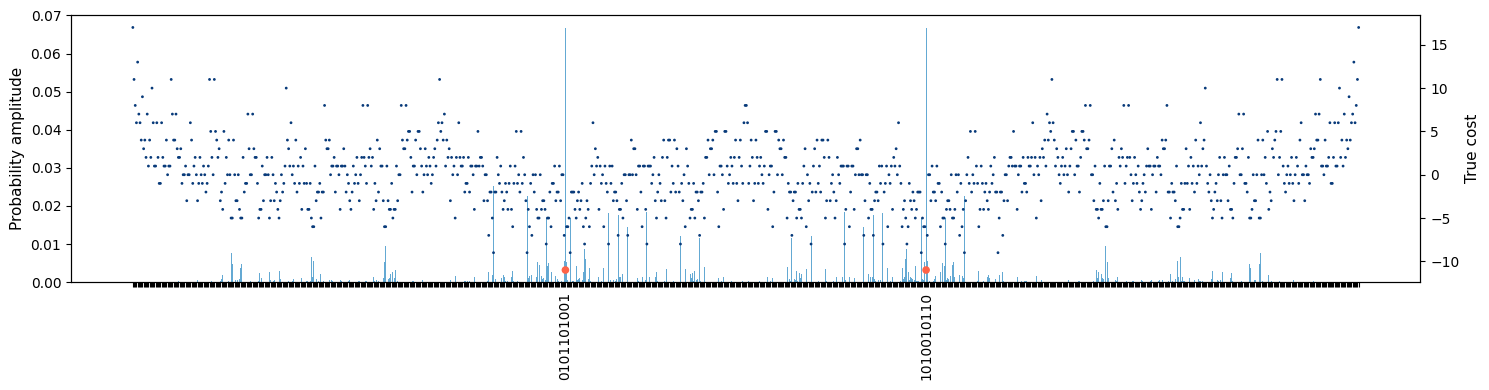

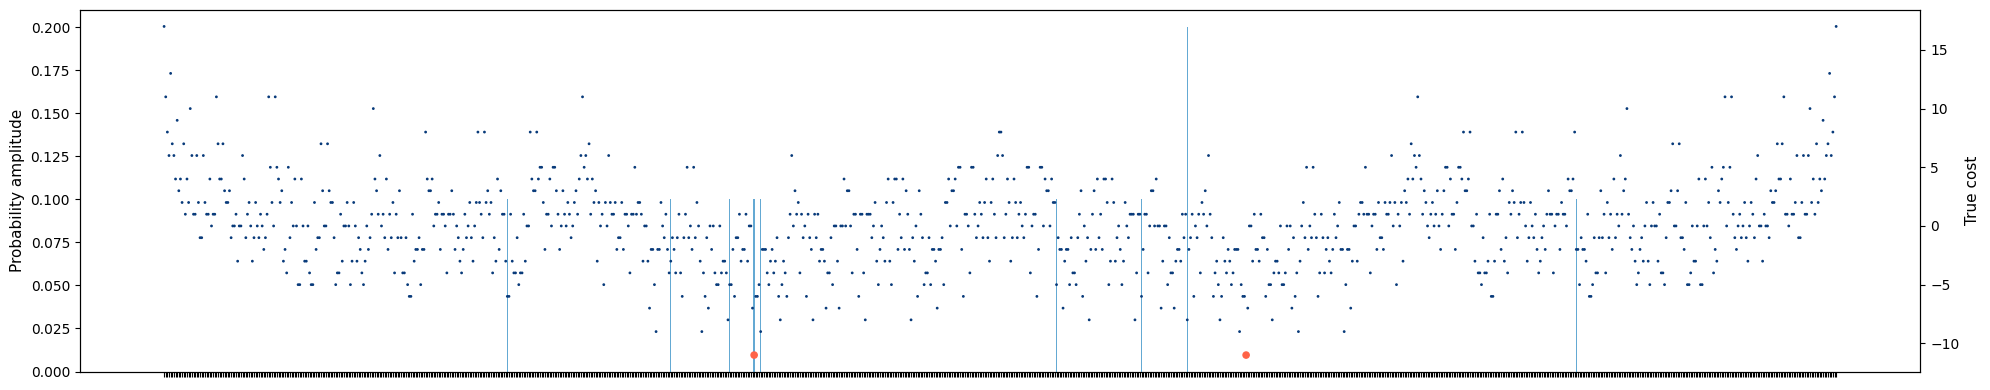

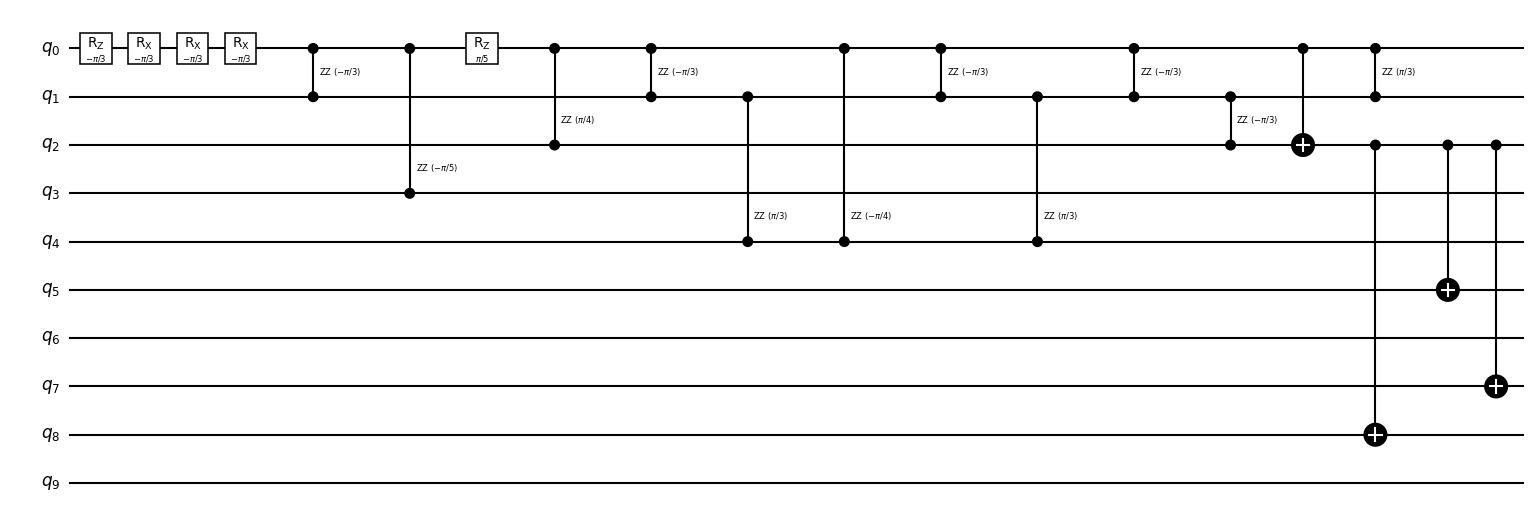

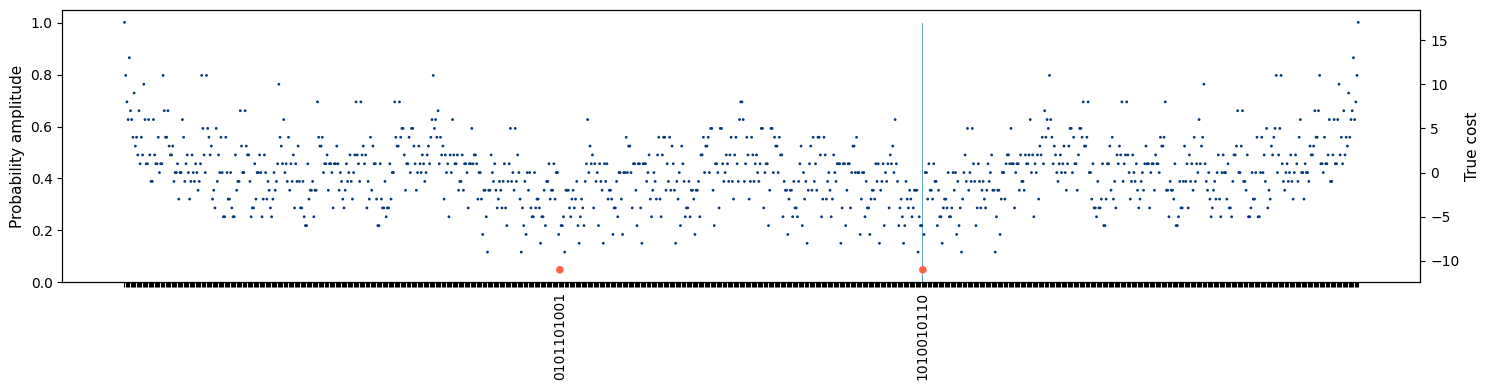

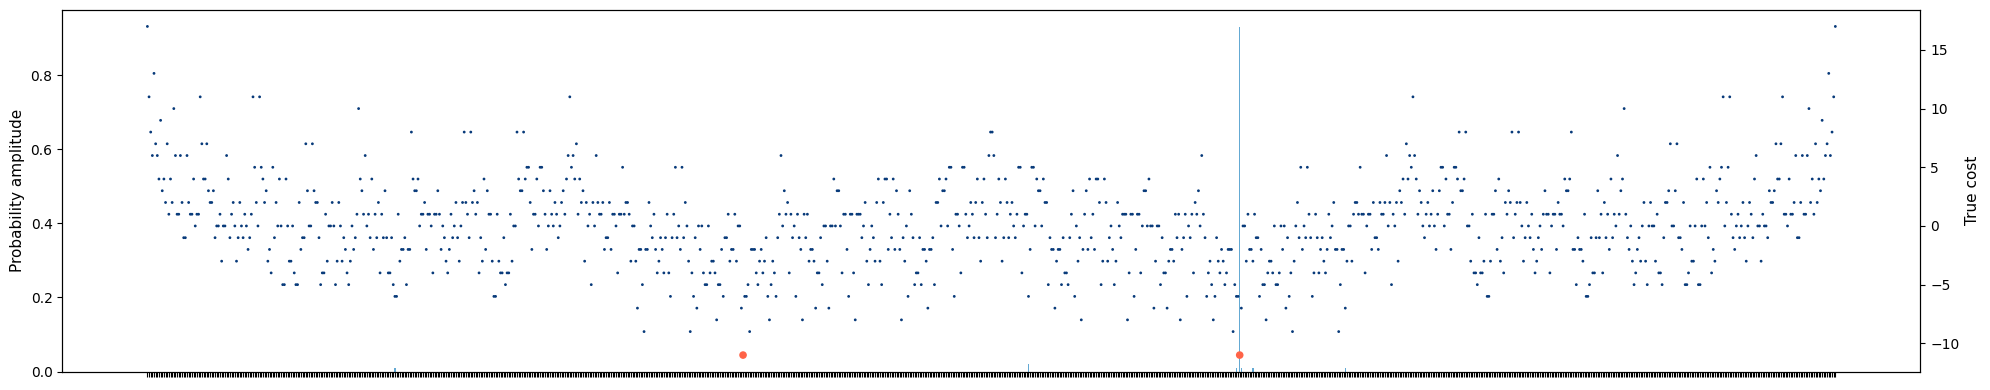

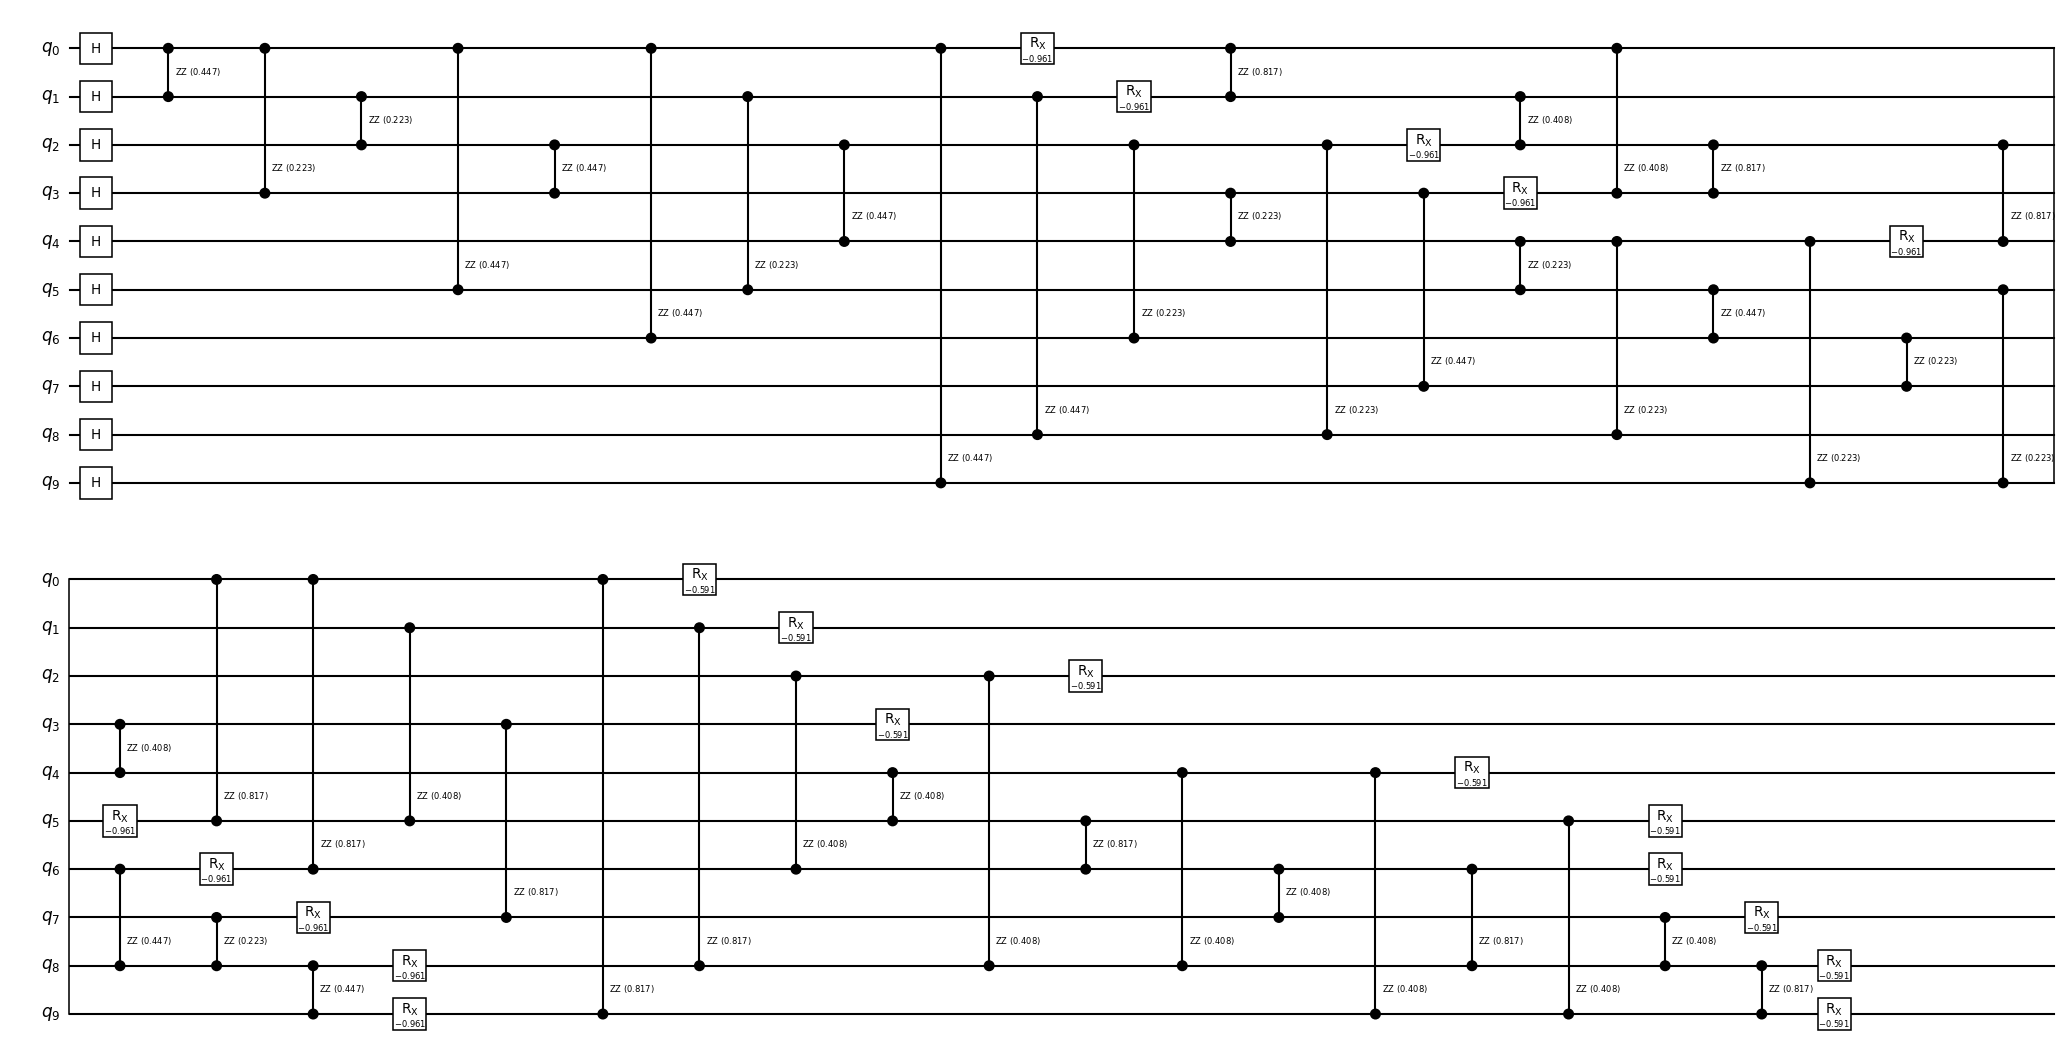

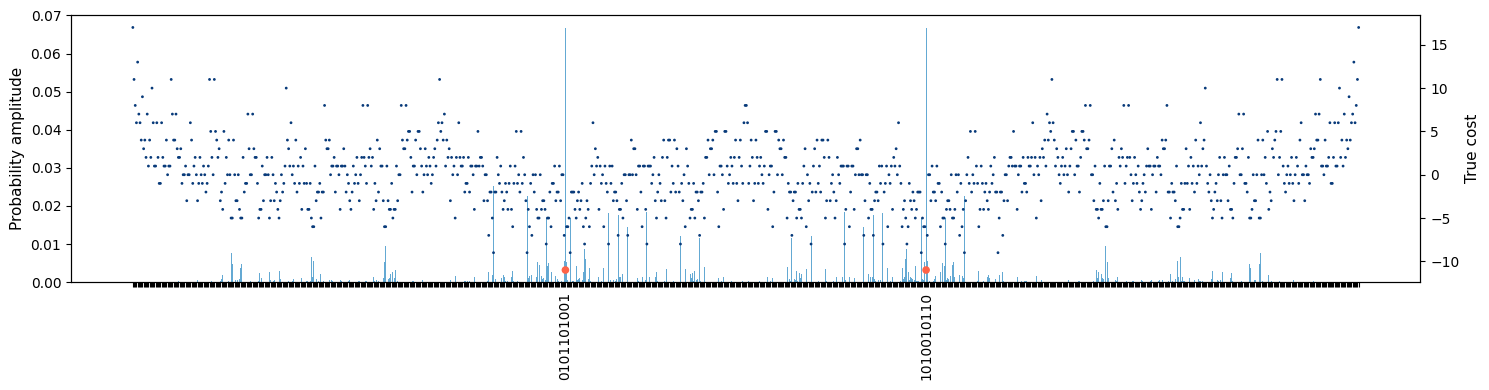

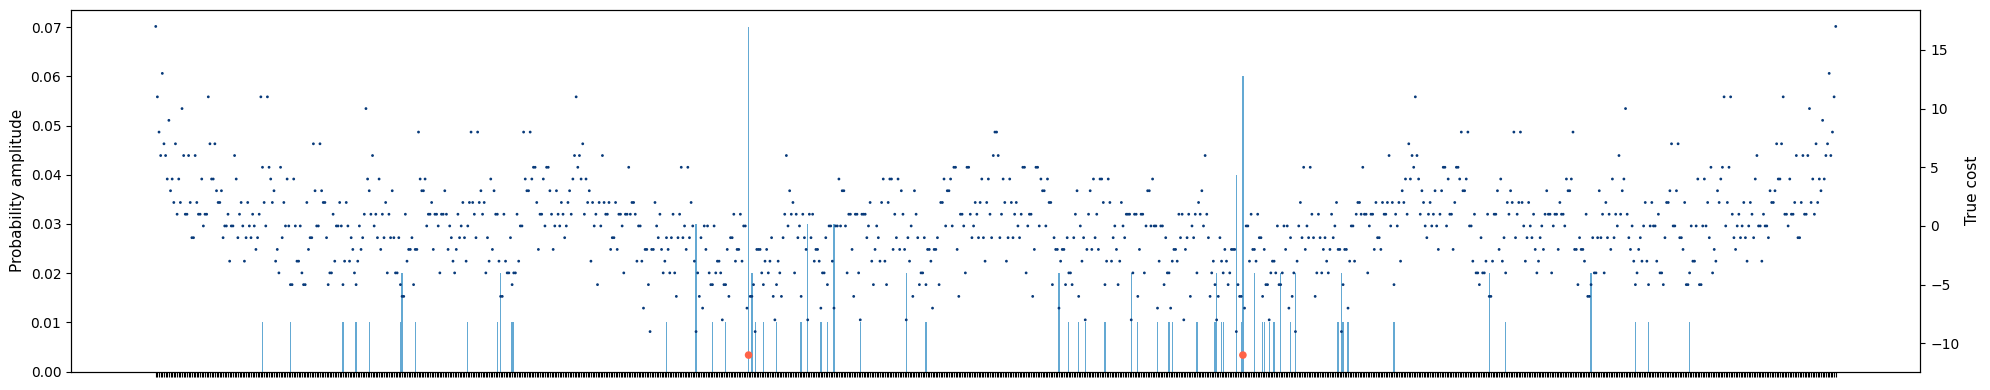

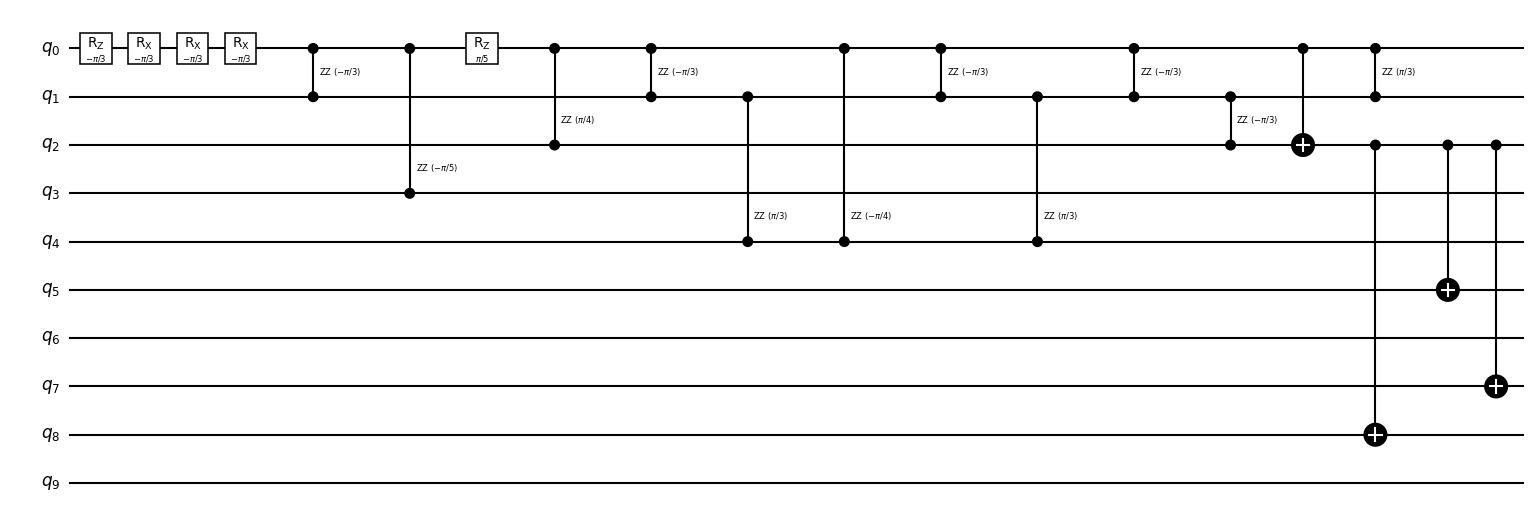

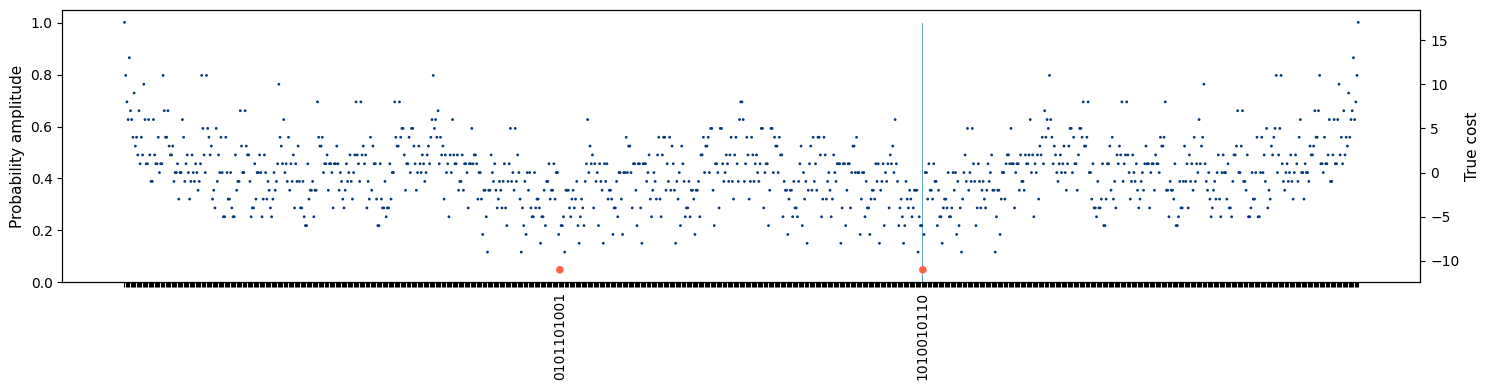

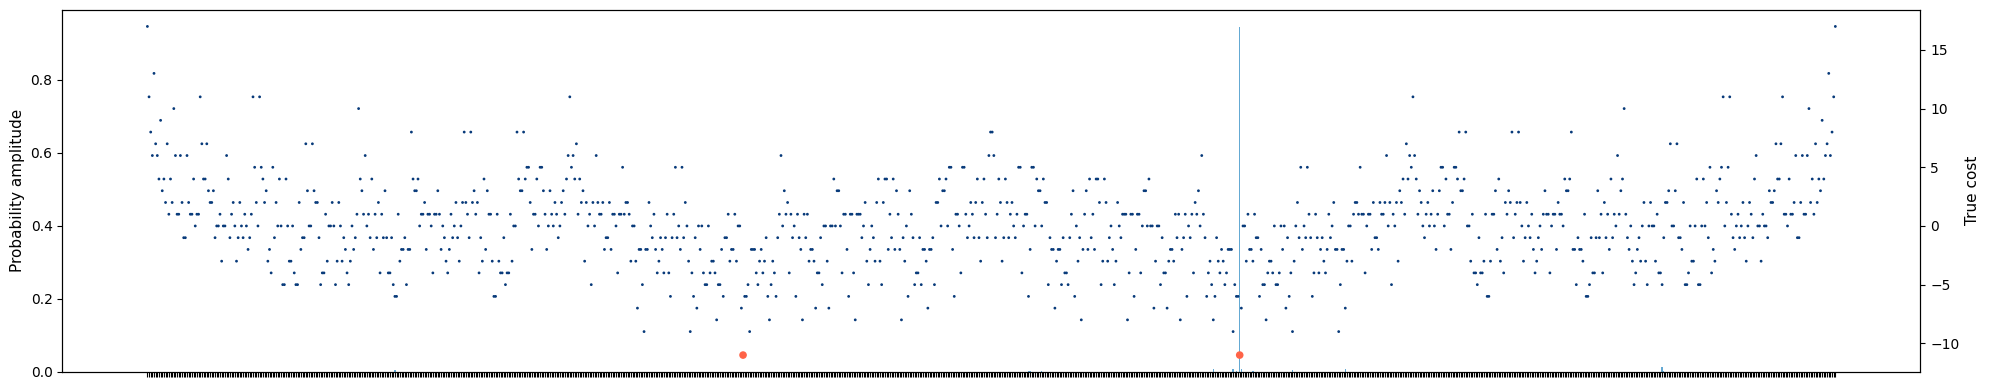

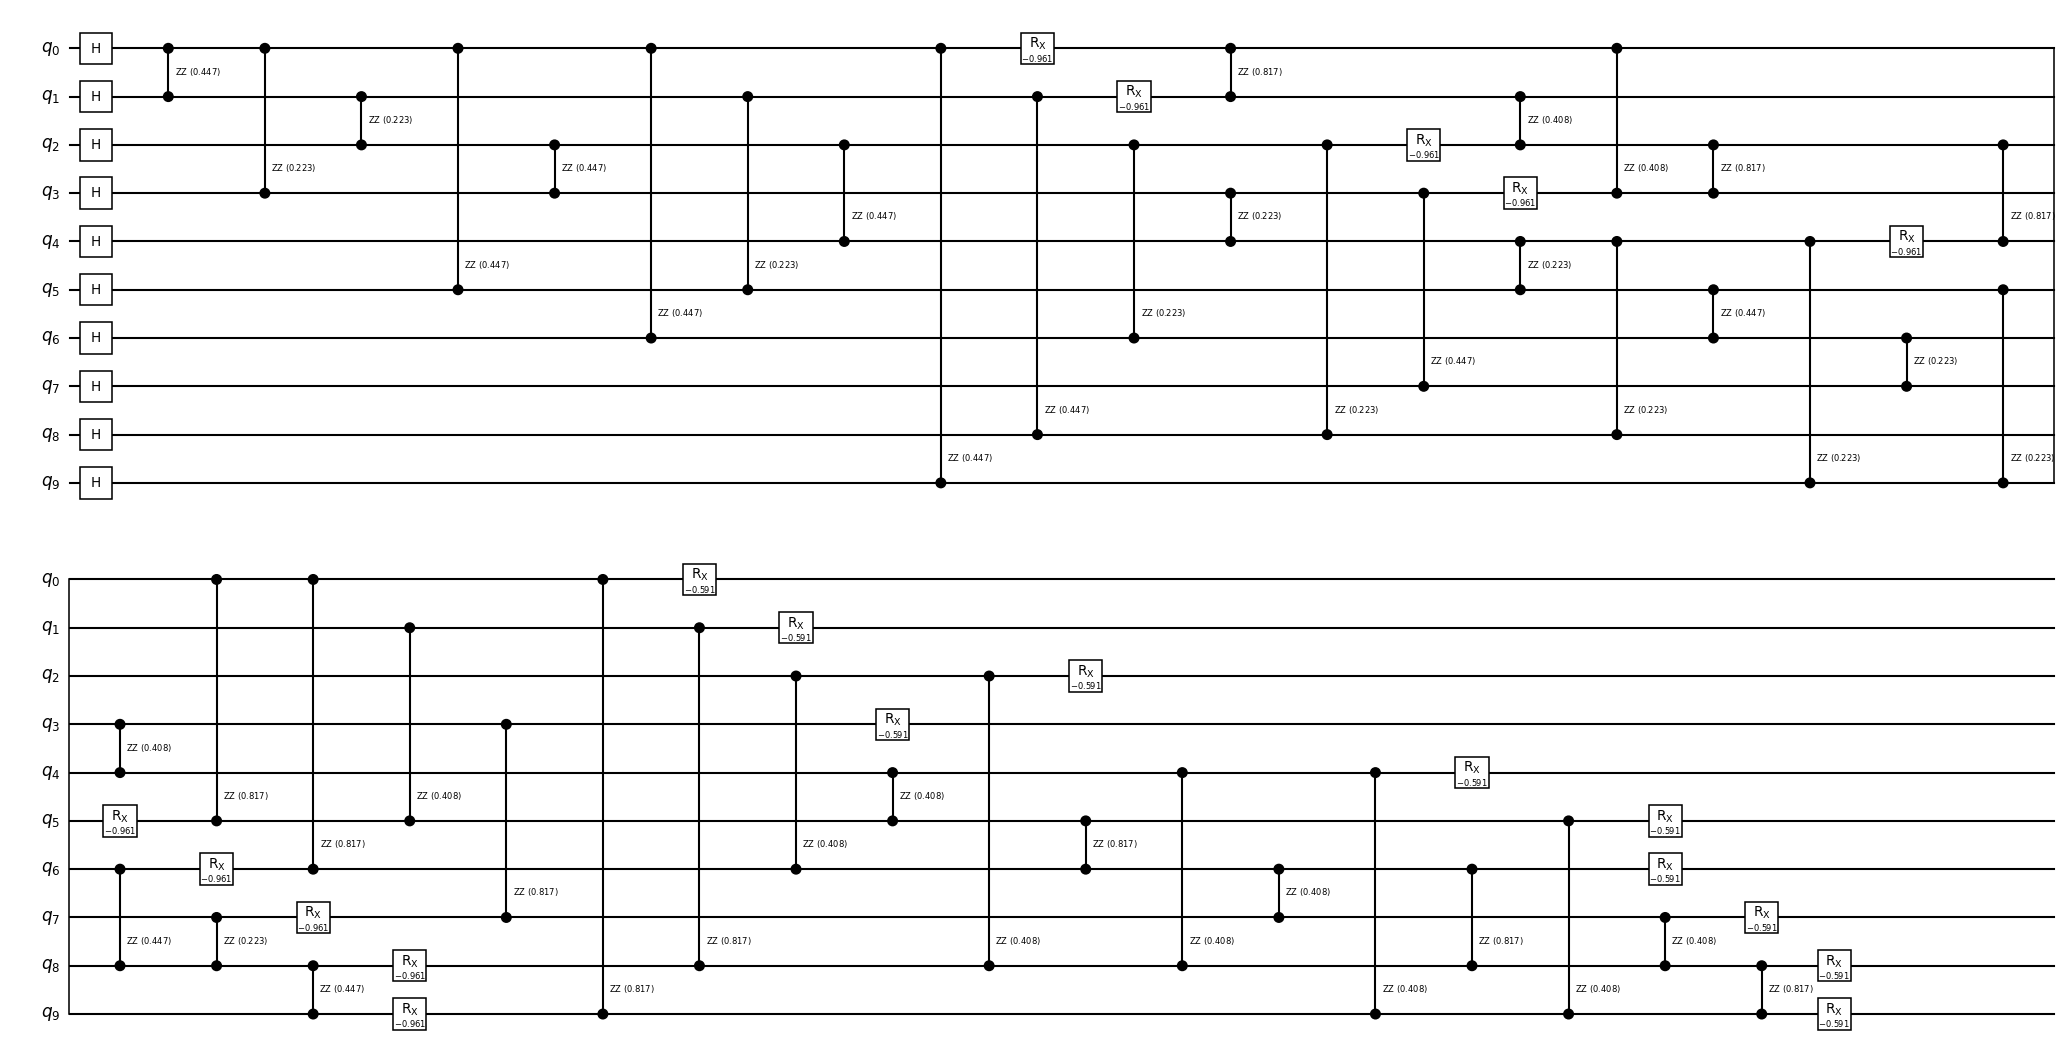

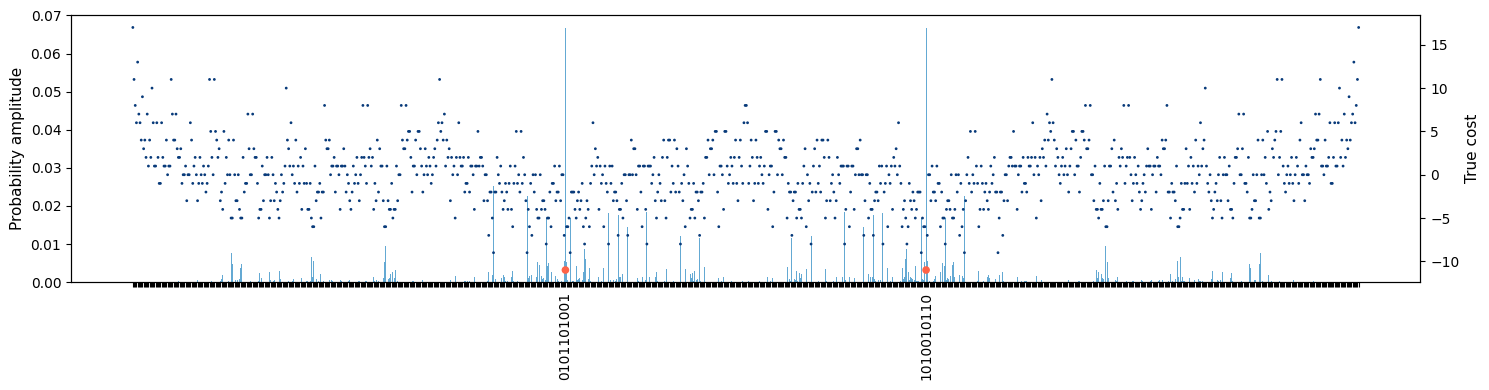

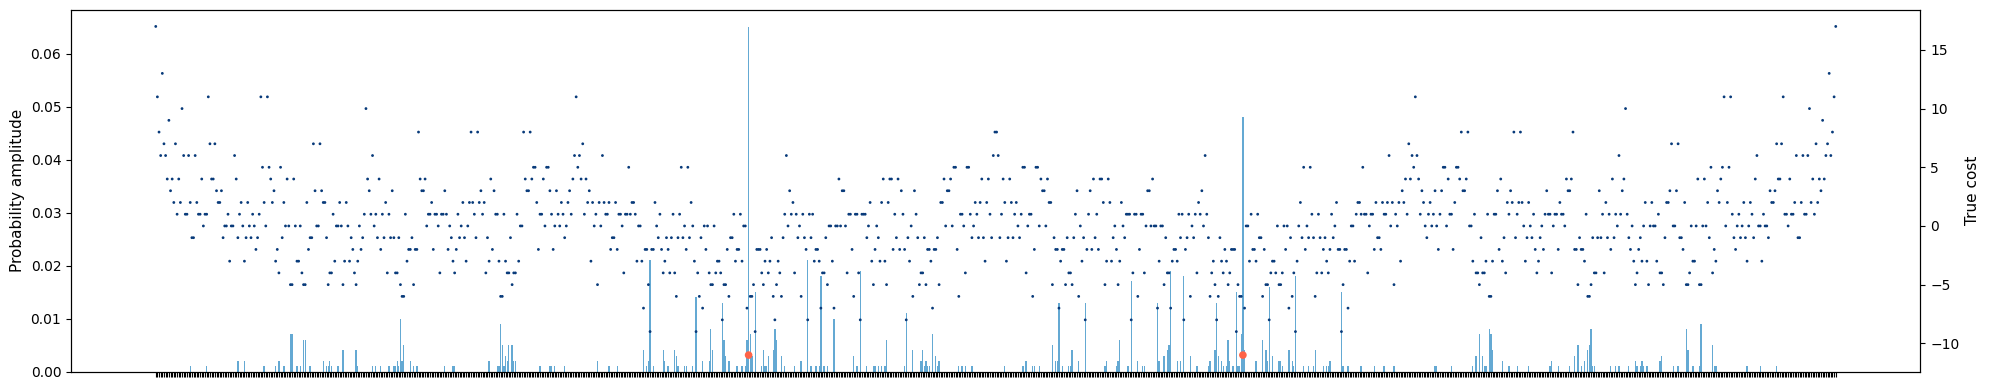

In [7]:
with open('./outputs/pkl/500/500_TrueCost.pkl', 'rb') as f:
    dict_true = pickle.load(f)

with open('./outputs/pkl/500/501_GQCOCircuit.pkl', 'rb') as f:
    qc_gqco = pickle.load(f)

with open('./outputs/pkl/500/502_QAOACircuit.pkl', 'rb') as f:
    qc_qaoa = pickle.load(f)


for smpl in [1, 10, 100, 1000]:
    with open(f'./outputs/json/results_gqco{smpl}.json', 'r') as f:
        result_gqco = json.load(f)
    
    with open(f'./outputs/json/results_qaoa{smpl}.json', 'r') as f:
        result_qaoa = json.load(f)
    
    dict_real_gqco = result_to_dict(result_gqco, dict_true, is_flip=True)
    dict_real_qaoa = result_to_dict(result_qaoa, dict_true, is_flip=False)
    
    draw_and_save(qc_gqco, dict_real_gqco, savename=f'./outputs/svg/521_GQCO-{smpl}')
    draw_and_save(qc_qaoa, dict_real_qaoa, savename=f'./outputs/svg/522_QAOA-{smpl}')